In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import lib.theme as theme
from lib.scoring import compute_kicktipp_score

In [14]:
df_predictions = pd.read_pickle("data/test_predictions.pickle")
df_predictions

,season,match_day,host_name,guest_name,host_goals,guest_goals,host_goals_pred,guest_goals_pred
id,,,,,,,,
66630,2023,1,Bremen,Bayern,0,4,1,2
66633,2023,1,Leverkusen,Leipzig,3,2,1,1
66635,2023,1,Wolfsburg,Heidenheim,2,0,2,1
66636,2023,1,Hoffenheim,Freiburg,1,2,2,1
66637,2023,1,Augsburg,Gladbach,4,4,1,1
...,...,...,...,...,...,...,...,...
66932,2023,34,Wolfsburg,Mainz,1,3,2,1
66933,2023,34,Hoffenheim,Bayern,4,2,1,2
66934,2023,34,Bremen,Bochum,4,1,2,1


In [15]:
predictions = df_predictions[["host_goals_pred", "guest_goals_pred"]].values
labels = df_predictions[["host_goals", "guest_goals"]].values
kicktipp_scores = np.zeros(len(labels))
for i in range(len(predictions)):
    kicktipp_scores[i] = compute_kicktipp_score(predictions[i:i+1], labels[i:i+1])
df_predictions["score"] = kicktipp_scores
df_predictions.tail()

,season,match_day,host_name,guest_name,host_goals,guest_goals,host_goals_pred,guest_goals_pred,score
id,,,,,,,,,
66932,2023,34,Wolfsburg,Mainz,1,3,2,1,0.0
66933,2023,34,Hoffenheim,Bayern,4,2,1,2,0.0
66934,2023,34,Bremen,Bochum,4,1,2,1,2.0
66935,2023,34,Stuttgart,Gladbach,4,0,1,1,0.0
66936,2023,34,Heidenheim,Köln,4,1,1,2,0.0


In [16]:
test_score = df_predictions["score"].sum().astype(int)
print(f"Achieved a score of {test_score} in {df_predictions['season'].mode()[0]}")

Achieved a score of 374 in 2023


In [18]:
on_host = np.count_nonzero(predictions[:, 0] > predictions[:, 1])
on_guest = np.count_nonzero(predictions[:, 1] > predictions[:, 0])
on_draw = np.count_nonzero(predictions[:, 0] == predictions[:, 1])

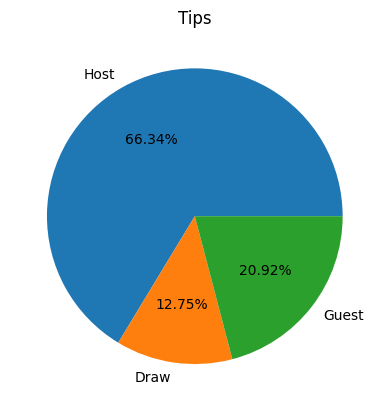

In [19]:
labels = 'Host', 'Draw', 'Guest' 
sizes = [on_host, on_draw, on_guest]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.2f%%')
ax.set_title("Tips")
!

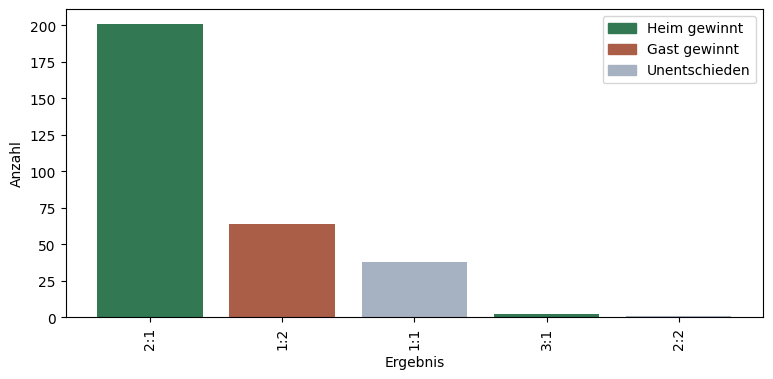

In [20]:
goals_encoded = [f"{int(r[0])}:{int(r[1])}" for r in predictions]
results, counts = np.unique(goals_encoded, return_counts=True)
sort = np.argsort(-counts)
counts = counts[sort]
results = results[sort]
tendency = [1] * len(results)
for i, res in enumerate(results):
    goals = res.split(":")
    if goals[0] > goals[1]:
        tendency[i] = 0
    elif goals[0] < goals[1]:
        tendency[i] = 2

y_test_colors = [[theme.MATCH_RESULT["host_wins"], theme.MATCH_RESULT["draw"], theme.MATCH_RESULT["guest_wins"]][r] for r in tendency]
fig, ax = plt.subplots(figsize=(9, 4))
ax.bar(range(len(results)), counts, color=y_test_colors)
ax.set_xlabel("Ergebnis")
ax.set_ylabel(f"Anzahl")
ax.set_xticks(range(len(results)), results, rotation=90)

orange_patch = mpatches.Patch(color=theme.MATCH_RESULT["guest_wins"], label='Gast gewinnt')
green_patch = mpatches.Patch(color=theme.MATCH_RESULT["host_wins"], label='Heim gewinnt')
blue_patch = mpatches.Patch(color=theme.MATCH_RESULT["draw"], label='Unentschieden')
ax.legend(handles=[green_patch, orange_patch, blue_patch])

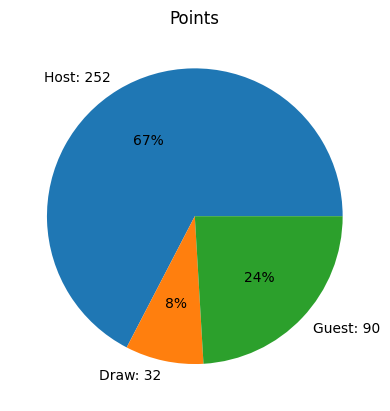

In [21]:
host_scores = df_predictions.loc[df_predictions["host_goals_pred"] > df_predictions["guest_goals_pred"], "score"].sum().astype(int)
guest_scores = df_predictions.loc[df_predictions["host_goals_pred"] < df_predictions["guest_goals_pred"], "score"].sum().astype(int)
draw_scores = df_predictions.loc[df_predictions["host_goals_pred"] == df_predictions["guest_goals_pred"], "score"].sum().astype(int)

labels = 'Host: ', 'Draw: ', 'Guest: ' 
labels = [l + str(s) for l, s in zip(labels, [host_scores, draw_scores, guest_scores])]
sizes = [host_scores, draw_scores, guest_scores]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1d%%')
ax.set_title("Points")
!

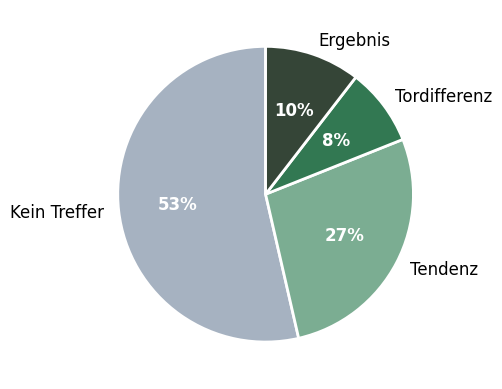

In [22]:
no_score = np.count_nonzero(kicktipp_scores == 0)
correct_result = np.count_nonzero(kicktipp_scores == 4)
correct_diff = np.count_nonzero(kicktipp_scores == 3)
correct_tendency = np.count_nonzero(kicktipp_scores == 2)

labels = 'Kein Treffer', 'Tendenz', 'Tordifferenz', 'Ergebnis'
sizes = [no_score, correct_tendency, correct_diff,  correct_result]
color = [theme.GRAY, theme.GRASS_B, theme.GRASS, theme.GRASS_D]

fig, ax = plt.subplots()
_, labels, value_labels = ax.pie(sizes, labels=labels, autopct='%1.1d%%', startangle=90,  colors=color, textprops={'fontsize': 12}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})
for l in value_labels:
    l.set_color("white")
    l.set_fontweight("bold")


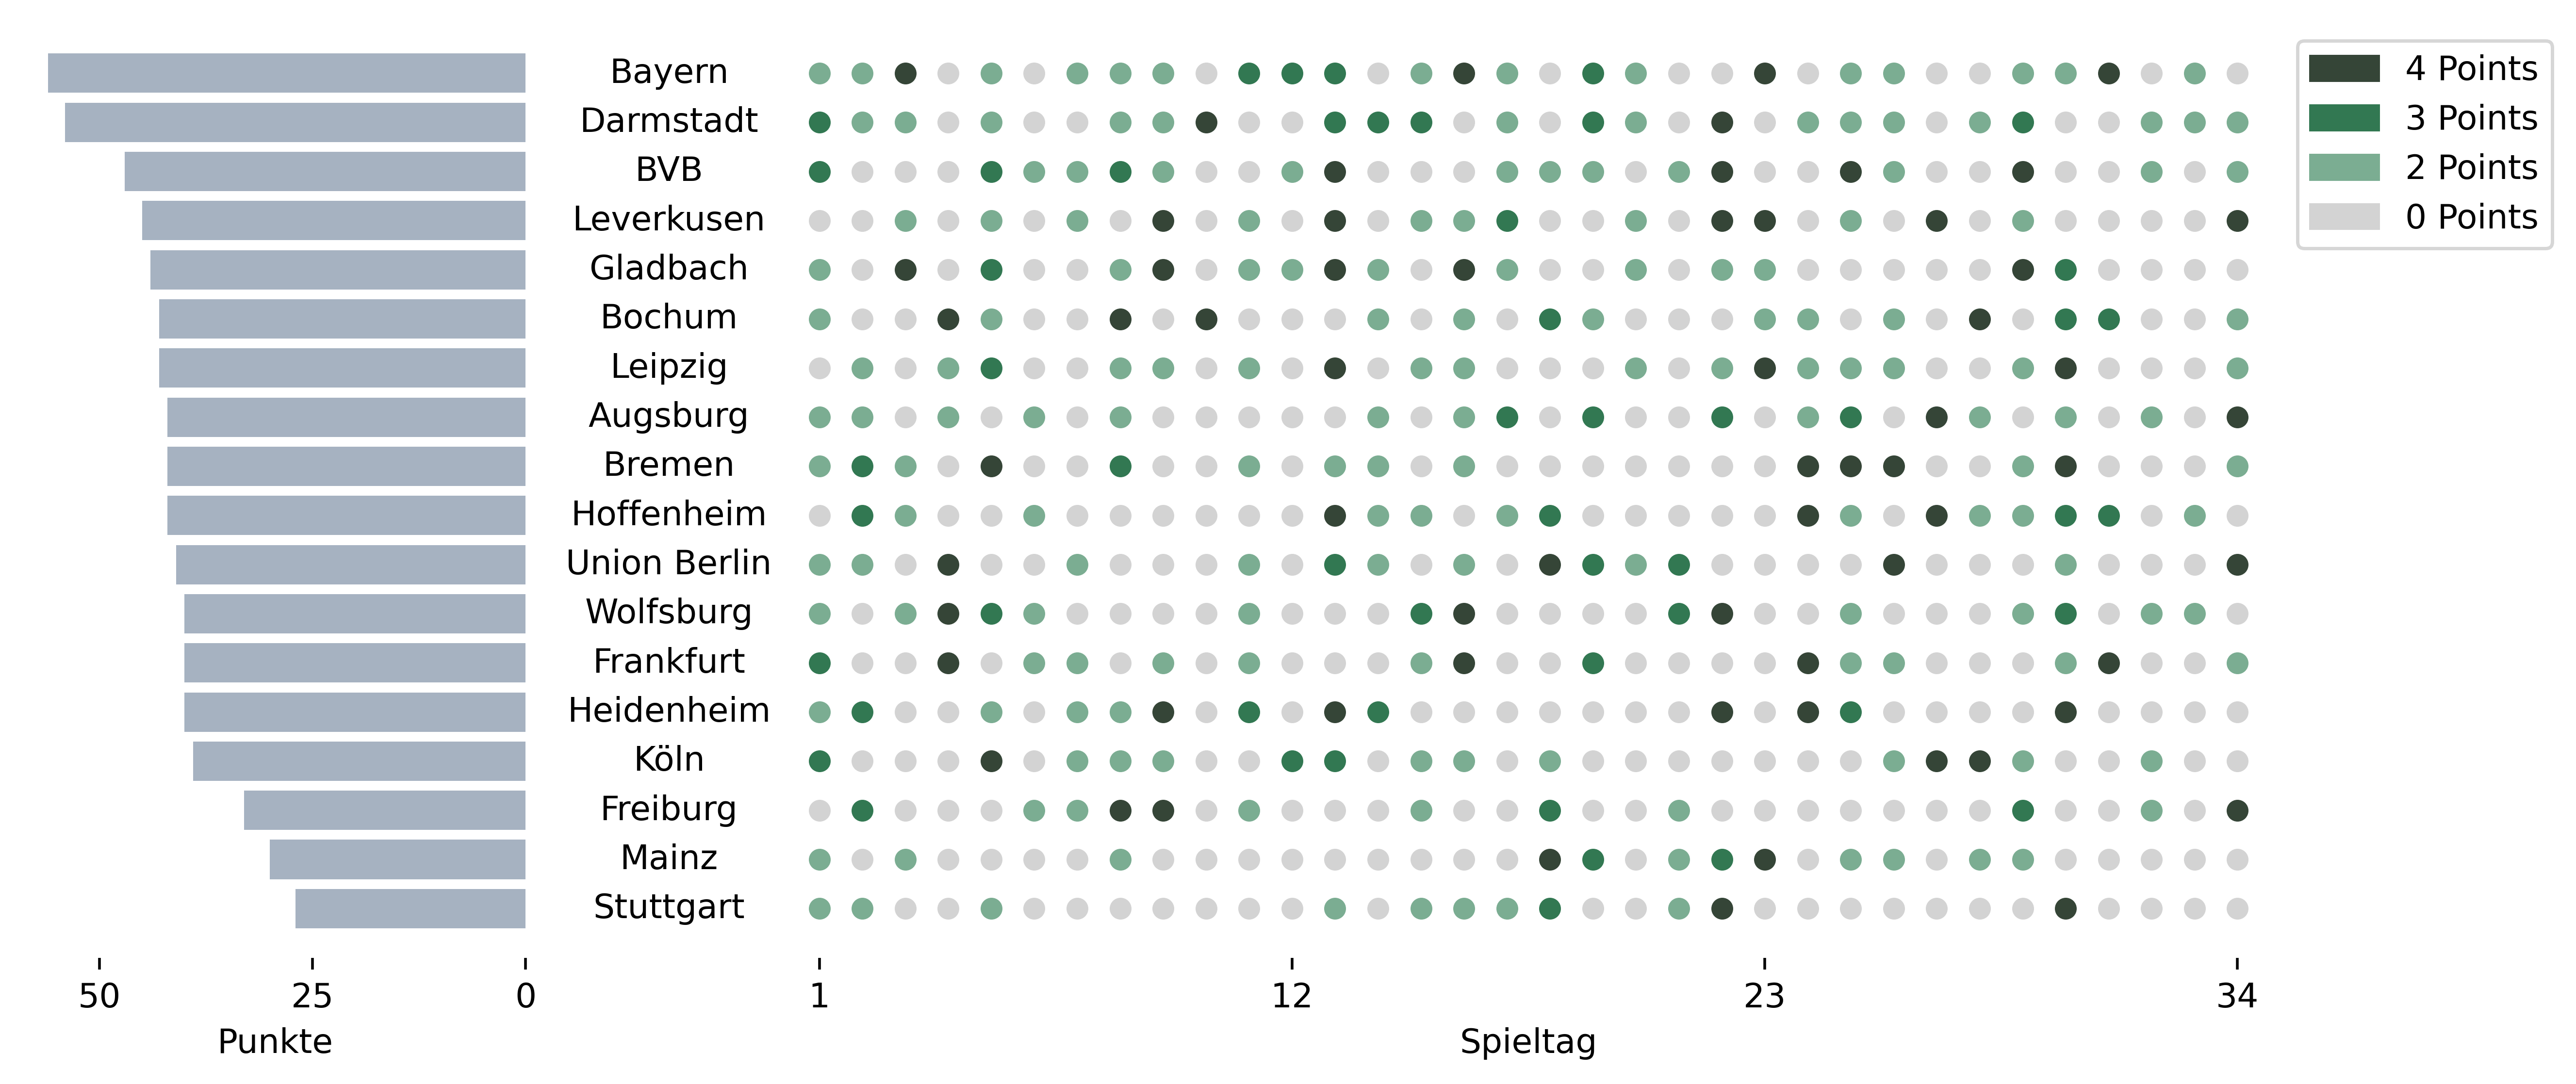

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.25}, dpi=500)

ax = axs[0]
team_host_scores = df_predictions[["host_name", "score"]].groupby(["host_name"]).sum().sort_index()
team_guest_scores = df_predictions[["guest_name", "score"]].groupby(["guest_name"]).sum().sort_index()
team_scores = team_host_scores["score"].values + team_guest_scores["score"].values
sort = np.argsort(team_scores)
team_scores = team_scores[sort].astype(int)
team_names = team_host_scores.index.values
team_names = team_names[sort]

color = [theme.GRAY] * len(team_names)
color = np.array(color)
#color[:3] = theme.MATCH_RESULT["guest_wins"]
#color[-3:] = theme.GRASS_D
ax.invert_xaxis()
rects = ax.barh(team_names, team_scores, color=color)
ax.set_frame_on(False)
#ax.bar_label(rects, team_scores, padding=5)
ax.set_xlabel("Punkte")
ax.set_xticks([0, 25, 50])


ax = axs[1]
ax.set_xlim(0, 34 + 1)
ax.set_ylim(-1, 18)
ax.set_xlabel("Spieltag")
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks(range(1, 36, 11))
ax.set_frame_on(False)

for i, team in enumerate(team_names):
    ax.text(-2.5, i, team, horizontalalignment="center", verticalalignment="center")
    for matchday in range(1, 34 + 1):
        s = df_predictions.loc[(df_predictions["match_day"] == matchday) & ((df_predictions["host_name"] == team) | (df_predictions["guest_name"] == team)), "score"].values[0]
        if s == 4:
            color = theme.GRASS_D
        elif s == 3:
            color = theme.GRASS
        elif s == 2:
            color = theme.GRASS_B
        else:
            color = "lightgray"
        ax.scatter(matchday, i, s=30, color=color)

green_patch = mpatches.Patch(color=theme.GRASS_D, label='4 Points')
orange_patch = mpatches.Patch(color=theme.GRASS, label='3 Points')
blue_patch = mpatches.Patch(color=theme.GRASS_B, label='2 Points')
gray_patch = mpatches.Patch(color='lightgray', label='0 Points')
ax.legend(handles=[green_patch, orange_patch, blue_patch, gray_patch], loc="upper left", bbox_to_anchor=(1.0, 1.0))

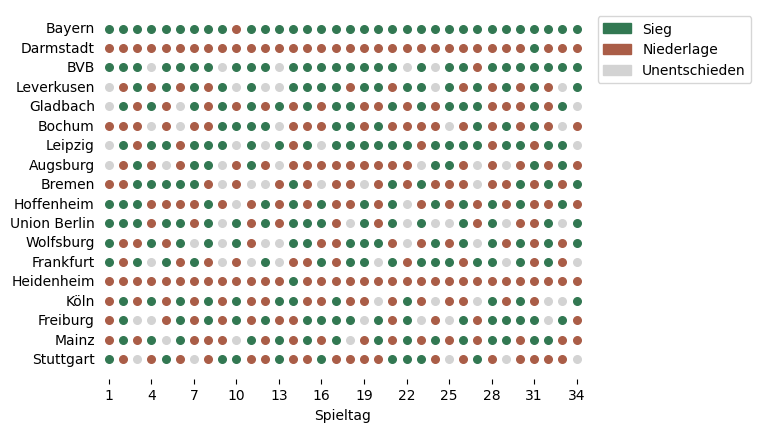

In [24]:
fig, ax = plt.subplots()
ax.set_xlim(0, 34 + 1)
ax.set_ylim(-1, 18)
ax.set_xlabel("Spieltag")
ax.get_yaxis().set_ticks([])
ax.get_xaxis().set_ticks(range(1, 36, 3))
ax.set_frame_on(False)

for i, team in enumerate(team_names):
    ax.text(0, i, team, horizontalalignment="right", verticalalignment="center")
    for matchday in range(1, 34 + 1):
        match = df_predictions[(df_predictions["match_day"] == matchday) & ((df_predictions["host_name"] == team) | (df_predictions["guest_name"] == team))].iloc[0]
        if match["host_name"] == team and match["host_goals_pred"] > match["guest_goals_pred"]:
            color = theme.MATCH_RESULT["host_wins"]
        elif match["guest_name"] == team and match["host_goals_pred"] < match["guest_goals_pred"]:
            color = theme.MATCH_RESULT["host_wins"]
        elif match["host_name"] == team and match["host_goals_pred"] < match["guest_goals_pred"]:
            color = theme.MATCH_RESULT["guest_wins"]
        elif match["guest_name"] == team and match["host_goals_pred"] > match["guest_goals_pred"]:
            color = theme.MATCH_RESULT["guest_wins"]
        else:
            color = "lightgray"
        ax.scatter(matchday, i, s=30, color=color)

green_patch = mpatches.Patch(color=theme.MATCH_RESULT["host_wins"], label='Sieg')
orange_patch = mpatches.Patch(color=theme.MATCH_RESULT["guest_wins"], label='Niederlage')
gray_patch = mpatches.Patch(color='lightgray', label='Unentschieden')
ax.legend(handles=[green_patch, orange_patch, gray_patch], loc="upper left", bbox_to_anchor=(1.0, 1.0))